In [1]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RX
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer,MQLayer,MQAnsatzOnlyOps
from mindquantum.simulator import Simulator
from mindspore.common.initializer import Normal,initializer
from mindspore import Tensor,ops
from mindspore import dtype as mstype
from mindspore.common.parameter import Parameter
from mindspore.nn import Adam, TrainOneStepCell                   # 导入Adam模块和TrainOneStepCell模块

import networkx as nx
import mindspore.nn as nn
import mindspore as ms


# 加载额外需要用到的包
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import time


import warnings
warnings.filterwarnings("ignore")

# 将数据保存在服务器上所需代码
import logging
import sys
import datetime
 
def init_logger(filename, logger_name):
    '''
    @brief:
        initialize logger that redirect info to a file just in case we lost connection to the notebook
    @params:
        filename: to which file should we log all the info
        logger_name: an alias to the logger
    '''
 
    # get current timestamp
    timestamp = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')
    
    logging.basicConfig(
        level=logging.INFO, 
        format='%(message)s',
#         format='%(message)s',
        handlers=[
            logging.FileHandler(filename=filename),
            logging.StreamHandler(sys.stdout)
        ]
    )
 
    # Test
    logger = logging.getLogger(logger_name)
   #logger.info('### Init. Logger {} ###'.format(logger_name))
    return logger


# Initialize
my_logger = init_logger("data/MLI/test.log", "ml_logger")



In [2]:
# n 是图 G 的顶点数，同时也是量子比特的个数
# 选择n个顶点的3正则图
n = 10
g = nx.Graph()
V = range(n)
g.add_nodes_from(V)

# 对应论文中Figure8中n = 8
# E = [(2, 7), (2, 1), (2, 3), (7, 4), (7, 5), (1, 0), (1, 4), (4, 0), (0, 6), (5, 6), (5, 3), (6, 3)] # random2


# 对应论文中Figure8中n = 10
# E = [(1, 2), (1, 0), (1, 5), (2, 8), (2, 3), (0, 4), (0, 3), (6, 9), (6, 7), (6, 8), (9, 8), (9, 7), (7, 5), (4, 5), (4, 3)]

# 10顶点3正则图，对应论文中Table
E = [(0, 5), (0, 6), (0, 7), (1, 2), (1, 8), (1, 9), (2, 3), (2, 5), (3, 8), (3, 9), (4, 7), (4, 8), (4, 9), (5, 6), (6, 7)]

# 对应论文中Figure8中n = 12
# E = [(1, 2), (1, 5), (1, 7), (2, 3), (2, 4), (5, 9), (5, 7), (9, 4), (9, 0), (4, 8), (8, 11), (8, 3), (6, 11), (6, 10), (6, 0), (11, 0), (3, 10), (10, 7)]

# 额外实验补充,14顶点3正则图
# E = [(3, 7), (3, 9), (3, 12), (7, 9), (7, 1), (4, 6), (4, 12), (4, 10), (6, 11), (6, 10), (12, 8), (5, 13), (5, 0), (5, 2), (13, 11), (13, 2), (8, 9), (8, 0), (0, 1), (2, 1), (11, 10)]

In [3]:
# 8顶点3正则图
# E = [(0,1),(0,3),(0,5),(1,2),(1,6),(2,3),(2,7),(3,4),(4,5),(4,7),(5,6),(6,7)] # 8顶点3正则图1
# E = [(0, 7), (0, 4), (0, 5), (7, 3), (7, 4), (1, 2), (1, 4), (1, 6), (2, 3), (2, 6), (3, 5), (6, 5)] #8顶点3正则图2
# E = [(0, 4), (0, 3), (0, 2), (4, 6), (4, 5), (2, 7), (2, 6), (7, 6), (7, 1), (1, 5), (1, 3), (5, 3)] # 8顶点3正则图3
# E = [(0, 1), (0, 6), (0, 5), (1, 4), (1, 3), (2, 4), (2, 7), (2, 6), (4, 6), (7, 3), (7, 5), (3, 5)] #图4
# E = [(0, 1), (0, 4), (0, 2), (1, 2), (1, 6), (2, 5), (4, 3), (4, 7), (3, 6), (3, 5), (5, 7), (7, 6)]  # 图5
# E = [(0, 1), (0, 7), (0, 5), (1, 4), (1, 6), (7, 3), (7, 5), (2, 4), (2, 3), (2, 6), (4, 5), (3, 6)]  #图6
# E = [(1, 2), (1, 4), (1, 7), (2, 7), (2, 5), (7, 3), (3, 0), (3, 6), (0, 6), (0, 5), (4, 6), (4, 5)] # 图7
# E = [(2, 4), (2, 1), (2, 3), (4, 0), (4, 7), (1, 5), (1, 7), (0, 6), (0, 5), (5, 6), (3, 7), (3, 6)] # 图8
# E = [(0, 1), (0, 3), (0, 6), (1, 4), (1, 6), (2, 7), (2, 3), (2, 5), (7, 5), (7, 4), (3, 6), (5, 4)] # 图9
# E = [(1, 2), (1, 6), (1, 3), (2, 7), (2, 5), (0, 4), (0, 3), (0, 6), (4, 6), (4, 5), (7, 3), (7, 5)] #图10


# E = [(0, 7), (0, 4), (0, 6), (7, 3), (7, 5), (2, 4), (2, 3), (2, 5), (4, 1), (1, 5), (1, 6), (3, 6)] # 图11
# E = [(0, 1), (0, 2), (0, 5), (1, 2), (1, 7), (2, 6), (3, 4), (3, 7), (3, 6), (4, 6), (4, 5), (7, 5)] # 图12
# E = [(0, 1), (0, 6), (0, 2), (1, 4), (1, 3), (2, 7), (2, 6), (7, 3), (7, 5), (3, 5), (4, 6), (4, 5)] # 图13
# E = [(0, 7), (0, 6), (0, 5), (7, 2), (7, 4), (1, 2), (1, 4), (1, 6), (2, 3), (3, 4), (3, 5), (6, 5)] # 图14
# E = [(1, 2), (1, 6), (1, 3), (2, 7), (2, 0), (0, 4), (0, 5), (4, 3), (4, 5), (3, 7), (7, 6), (6, 5)] # 图15
# E = [(0, 7), (0, 4), (0, 6), (7, 2), (7, 5), (1, 2), (1, 6), (1, 3), (2, 3), (4, 3), (4, 5), (5, 6)] # 图16
# E = [(0, 1), (0, 7), (0, 6), (1, 4), (1, 7), (7, 3), (3, 2), (3, 5), (4, 6), (4, 5), (6, 2), (2, 5)] # 图17
# E = [(0, 7), (0, 4), (0, 3), (7, 5), (7, 6), (2, 4), (2, 1), (2, 5), (4, 6), (1, 5), (1, 3), (3, 6)] # 图18
# E = [(0, 1), (0, 3), (0, 2), (1, 5), (1, 7), (2, 4), (2, 6), (4, 3), (4, 6), (3, 7), (5, 7), (5, 6)] # 图19
# E = [(1, 2), (1, 4), (1, 6), (2, 0), (2, 5), (3, 4), (3, 7), (3, 0), (4, 5), (7, 5), (7, 6), (0, 6)] # 图20


# E = [(0, 7), (0, 3), (0, 5), (7, 6), (7, 4), (1, 2), (1, 4), (1, 6), (2, 3), (2, 5), (3, 4), (6, 5)] # 图21
# E = [(0, 1), (0, 4), (0, 5), (1, 4), (1, 7), (4, 5), (3, 7), (3, 2), (3, 6), (7, 6), (2, 6), (2, 5)] # 图22
# E = [(0, 1), (0, 7), (0, 3), (1, 7), (1, 6), (7, 5), (2, 4), (2, 3), (2, 5), (4, 6), (4, 5), (3, 6)] # 图23
# E = [(0, 7), (0, 3), (0, 6), (7, 1), (7, 4), (2, 4), (2, 1), (2, 3), (4, 6), (1, 5), (5, 6), (5, 3)] # 图24
# E = [(0, 1), (0, 4), (0, 3), (1, 2), (1, 4), (2, 4), (2, 7), (7, 5), (7, 6), (3, 6), (3, 5), (5, 6)] # 图25
# E = [(0, 1), (0, 4), (0, 6), (1, 7), (1, 6), (4, 5), (4, 7), (3, 7), (3, 2), (3, 5), (6, 2), (2, 5)] # 图26


In [4]:
# 10顶点3正则图
# E =[(0,2),(0,5),(0,9),(1,3),(1,5),(1,8),(2,9),(2,4),(3,4),(3,6),(4,9),(5,7),(6,7),(6,8),(7,8)]  # 10顶点正则图1
# E = [(0,5),(0,6),(0,7),(1,2),(1,8),(1,9),(2,3),(2,5),(3,8),(3,9),(4,7),(4,8),(4,9),(5,6),(6,7)]   # 10顶点正则图2
# E = [(0,2),(0,8),(0,9),(1,4),(1,5),(1,7),(2,5),(2,8),(3,4),(3,6),(3,7),(4,9),(5,7),(6,8),(6,9)]  # 10 顶点正则图3
# E = [(0,3),(0,6),(0,9),(1,4),(1,7),(1,8),(2,5),(2,6),(2,8),(3,4),(3,7),(4,9),(5,6),(5,8),(7,9)]   # 10顶点正则图4
# E = [(0,2),(0,5),(0,7),(1,3),(1,4),(1,6),(2,5),(2,7),(3,8),(3,9),(4,8),(4,9),(5,7),(6,8),(6,9)]  # 3正则图5
# E = [(0,1),(0,6),(0,2),(1,2),(1,7),(2,5),(3,6),(3,8),(3,4),(4,7),(4,9),(5,7),(5,9),(6,8),(6,9)]  # 3正则图6
# E = [(2, 7), (2, 8), (2, 4), (7, 0), (7, 1), (5, 9), (5, 0), (5, 3), (9, 6), (9, 8), (6, 0), (6, 3), (8, 1), (1, 4), (4, 3)]#3正则图7
# E = [(0, 1), (0, 4), (0, 3), (1, 3), (1, 5), (7, 8), (7, 6), (7, 9), (8, 6), (8, 5), (2, 6), (2, 9), (2, 5), (4, 9), (4, 3)] # 3正则图8
# E = [(0, 1), (0, 3), (0, 5), (1, 5), (1, 7), (2, 4), (2, 9), (2, 8), (4, 9), (4, 6), (5, 3), (9, 8), (6, 7), (6, 3), (7, 8)] # 3正则图9
# E = [(0, 7), (0, 3), (0, 6), (7, 9), (7, 8), (2, 4), (2, 1), (2, 8), (4, 9), (4, 5), (1, 5), (1, 6), (5, 3), (9, 8), (3, 6)] # 3正则图10


# E = [(3, 8), (3, 7), (3, 1), (8, 9), (8, 2), (0, 4), (0, 6), (0, 5), (4, 6), (4, 7), (2, 7), (2, 9), (1, 5), (1, 6), (5, 9)] #图11
# E = [(0, 1), (0, 4), (0, 8), (1, 4), (1, 6), (4, 8), (2, 7), (2, 6), (2, 8), (7, 3), (7, 5), (3, 9), (3, 5), (5, 9), (9, 6)] # 图12
# E = [(0, 1), (0, 9), (0, 8), (1, 2), (1, 7), (2, 3), (2, 6), (3, 4), (3, 6), (4, 8), (4, 7), (5, 8), (5, 7), (5, 9), (9, 6)] # 图13
# E = [(0, 1), (0, 4), (0, 6), (1, 5), (1, 9), (3, 8), (3, 7), (3, 5), (8, 9), (8, 2), (2, 4), (2, 5), (4, 6), (7, 9), (7, 6)] # 图14
# E = [(0, 1), (0, 9), (0, 5), (1, 4), (1, 9), (3, 8), (3, 7), (3, 5), (8, 9), (8, 4), (2, 7), (2, 6), (2, 5), (7, 6), (4, 6)] # 图15
# E = [(1, 2), (1, 7), (1, 3), (2, 3), (2, 8), (0, 4), (0, 9), (0, 8), (4, 9), (4, 6), (9, 5), (3, 7), (7, 5), (6, 8), (6, 5)] # 图16
# E = [(0, 1), (0, 2), (0, 8), (1, 6), (1, 7), (3, 4), (3, 2), (3, 5), (4, 6), (4, 8), (6, 7), (5, 7), (5, 9), (2, 9), (9, 8)] # 图17
# E = [(0, 1), (0, 6), (0, 8), (1, 9), (1, 6), (3, 4), (3, 7), (3, 5), (4, 5), (4, 7), (5, 8), (8, 2), (7, 9), (9, 2), (6, 2)] # 图18
# E = [(0, 4), (0, 3), (0, 8), (4, 3), (4, 9), (3, 9), (2, 7), (2, 5), (2, 8), (7, 1), (7, 8), (1, 5), (1, 6), (5, 6), (9, 6)] # 图19
# E = [(1, 2), (1, 4), (1, 9), (2, 5), (2, 8), (3, 4), (3, 7), (3, 6), (4, 5), (7, 9), (7, 8), (6, 8), (6, 0), (0, 9), (0, 5)] # 图20


# E = [(0, 1), (0, 9), (0, 6), (1, 2), (1, 7), (3, 8), (3, 4), (3, 2), (8, 4), (8, 7), (2, 5), (4, 6), (6, 5), (9, 7), (9, 5)] #图21
# E = [(1, 3), (1, 2), (1, 8), (3, 8), (3, 5), (8, 0), (2, 7), (2, 9), (0, 4), (0, 7), (4, 6), (4, 5), (7, 6), (6, 9), (9, 5)] # 图22
# E = [(0, 1), (0, 6), (0, 5), (1, 8), (1, 9), (3, 8), (3, 4), (3, 7), (8, 2), (2, 4), (2, 6), (4, 9), (9, 5), (7, 5), (7, 6)] # 图23
# E = [(2, 4), (2, 9), (2, 0), (4, 3), (4, 5), (3, 0), (3, 1), (6, 8), (6, 0), (6, 5), (8, 1), (8, 7), (1, 9), (5, 7), (7, 9)] #图24
# E = [(0, 1), (0, 3), (0, 2), (1, 6), (1, 3), (3, 4), (4, 8), (4, 7), (7, 9), (7, 8), (9, 8), (9, 5), (2, 6), (2, 5), (6, 5)] #图25
# E = [(0, 1), (0, 7), (0, 4), (1, 8), (1, 6), (7, 9), (7, 4), (4, 3), (3, 9), (3, 6), (5, 8), (5, 6), (5, 2), (8, 2), (9, 2)] # 图26
# E = [(0, 7), (0, 9), (0, 8), (7, 2), (7, 9), (3, 4), (3, 2), (3, 9), (4, 6), (4, 8), (2, 5), (1, 5), (1, 8), (1, 6), (5, 6)] # 图27
# E = [(0, 7), (0, 3), (0, 9), (7, 9), (7, 6), (3, 8), (3, 1), (8, 4), (8, 2), (1, 5), (1, 4), (5, 6), (5, 2), (4, 9), (6, 2)] #图28
# E = [(2, 4), (2, 9), (2, 0), (4, 9), (4, 8), (1, 5), (1, 7), (1, 6), (5, 6), (5, 0), (9, 8), (3, 7), (3, 0), (3, 6), (7, 8)] # 图29
# E = [(0, 1), (0, 7), (0, 5), (1, 2), (1, 6), (7, 3), (7, 5), (3, 8), (3, 9), (8, 5), (8, 4), (2, 9), (2, 6), (4, 9), (4, 6)] #图30


In [5]:
# 12顶点的3正则图
# E = [(0, 7), (0, 4), (0, 9), (7, 10), (7, 1), (2, 4), (2, 3), (2, 8), (4, 11), (10, 11), (10, 5), (11, 6), (6, 8), (6, 1), (8, 9), (9, 5), (3, 1), (3, 5)] # 12顶点3正则图1
# E = [(3, 8), (3, 7), (3, 1), (8, 4), (8, 0), (1, 2), (1, 9), (2, 10), (2, 11), (5, 11), (5, 6), (5, 0), (11, 4), (0, 10), (10, 7), (6, 9), (6, 4), (9, 7)]#图2
# E = [(1, 3), (1, 2), (1, 6), (3, 8), (3, 7), (8, 5), (8, 7), (2, 7), (2, 11), (10, 11), (10, 0), (10, 5), (11, 0), (0, 9), (6, 9), (6, 4), (9, 4), (4, 5)] # 图3
# E = [(3, 8), (3, 4), (3, 7), (8, 9), (8, 0), (4, 6), (4, 1), (1, 11), (1, 7), (11, 9), (11, 0), (7, 5), (2, 10), (2, 0), (2, 5), (10, 5), (10, 6), (6, 9)]#图4
# E = [(0, 1), (0, 2), (0, 5), (1, 6), (1, 9), (3, 8), (3, 10), (3, 9), (8, 6), (8, 4), (10, 11), (10, 5), (11, 7), (11, 4), (6, 2), (7, 9), (7, 4), (2, 5)] # 图5
# E = [(4, 10), (4, 9), (4, 1), (10, 7), (10, 5), (1, 2), (1, 8), (2, 3), (2, 5), (9, 7), (9, 11), (7, 11), (6, 8), (6, 0), (6, 3), (8, 11), (0, 3), (0, 5)] #图6
# E = [(9, 10), (9, 0), (9, 6), (10, 7), (10, 2), (0, 7), (0, 2), (7, 5), (3, 4), (3, 2), (3, 11), (4, 5), (4, 8), (5, 8), (8, 1), (6, 11), (6, 1), (11, 1)] # 图7
# E = [(1, 2), (1, 8), (1, 3), (2, 9), (2, 6), (0, 4), (0, 10), (0, 11), (4, 6), (4, 5), (10, 7), (10, 5), (5, 8), (8, 11), (6, 9), (9, 3), (7, 3), (7, 11)] # 图8
# E = [(0, 1), (0, 4), (0, 5), (1, 8), (1, 6), (3, 8), (3, 10), (3, 9), (8, 7), (4, 7), (4, 5), (2, 10), (2, 6), (2, 11), (10, 5), (7, 11), (6, 9), (9, 11)] #图9
# E = [(1, 3), (1, 6), (1, 7), (3, 4), (3, 10), (4, 6), (4, 7), (6, 7), (10, 8), (10, 5), (0, 9), (0, 8), (0, 11), (9, 5), (9, 11), (8, 2), (5, 2), (11, 2)] # 图10


# E = [(0, 1), (0, 10), (0, 11), (1, 4), (1, 10), (3, 4), (3, 7), (3, 6), (4, 5), (10, 5), (7, 9), (7, 6), (6, 8), (8, 11), (8, 2), (11, 9), (9, 2), (2, 5)]# 图11
# E = [(9, 10), (9, 8), (9, 5), (10, 11), (10, 6), (0, 1), (0, 4), (0, 2), (1, 7), (1, 3), (11, 5), (11, 6), (5, 6), (3, 4), (3, 2), (4, 8), (2, 7), (7, 8)] #图12
# E = [(4, 10), (4, 0), (4, 6), (10, 11), (10, 2), (3, 8), (3, 0), (3, 2), (8, 0), (8, 11), (11, 1), (1, 5), (1, 7), (5, 7), (5, 9), (2, 9), (6, 7), (6, 9)] # 图13
# E = [(2, 4), (2, 9), (2, 0), (4, 7), (4, 11), (10, 11), (10, 3), (10, 5), (11, 3), (5, 8), (5, 1), (8, 6), (8, 0), (1, 6), (1, 9), (3, 7), (7, 9), (6, 0)] #图14
# E = [(4, 10), (4, 0), (4, 8), (10, 11), (10, 2), (11, 6), (11, 1), (0, 3), (0, 5), (6, 8), (6, 1), (1, 7), (5, 8), (5, 7), (2, 3), (2, 9), (3, 9), (7, 9)] #图15
# E = [(9, 10), (9, 3), (9, 6), (10, 11), (10, 3), (2, 4), (2, 1), (2, 8), (4, 0), (4, 7), (1, 7), (1, 6), (8, 0), (8, 7), (5, 11), (5, 6), (5, 0), (11, 3)]#图16
# E = [(9, 10), (9, 4), (9, 11), (10, 4), (10, 3), (0, 7), (0, 6), (0, 2), (7, 2), (7, 1), (4, 3), (1, 2), (1, 5), (3, 8), (8, 5), (8, 11), (6, 11), (6, 5)]#图17
# E = [(1, 3), (1, 6), (1, 9), (3, 8), (3, 9), (8, 0), (8, 11), (10, 11), (10, 5), (10, 6), (11, 2), (2, 4), (2, 6), (4, 9), (4, 7), (0, 7), (0, 5), (7, 5)]#图18
# E = [(9, 10), (9, 0), (9, 1), (10, 7), (10, 8), (2, 4), (2, 3), (2, 0), (4, 7), (4, 8), (5, 11), (5, 1), (5, 3), (11, 6), (11, 0), (1, 3), (6, 8), (6, 7)]#图19
# E = [(9, 10), (9, 2), (9, 11), (10, 11), (10, 8), (0, 7), (0, 4), (0, 5), (7, 2), (7, 8), (3, 8), (3, 4), (3, 11), (1, 2), (1, 5), (1, 6), (4, 6), (5, 6)]#图20

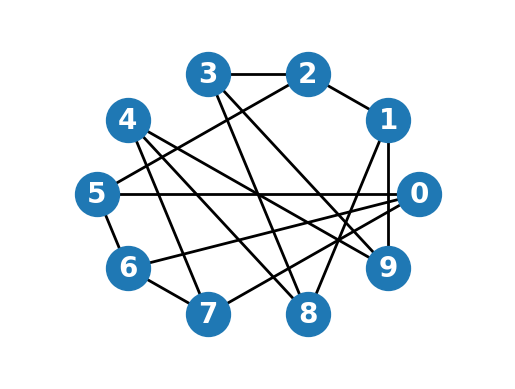

E = [(0, 5), (0, 6), (0, 7), (1, 2), (1, 8), (1, 9), (2, 3), (2, 5), (3, 8), (3, 9), (4, 7), (4, 8), (4, 9), (5, 6), (6, 7)]


In [6]:
g.add_edges_from(E)
# 将生成的图 G 打印出来
pos = nx.circular_layout(g)
options = {
    "with_labels": True,
    "font_size": 20,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 1000,
    "width": 2
}
nx.draw_networkx(g, pos, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

my_logger.info('E = {}'.format(E))

In [7]:
def build_hc(g, para):
    hc = Circuit()                  # 创建量子线路
    for i in g.edges:
        hc += ZZ(para).on(i)        # 对图中的每条边作用ZZ门
    hc.barrier()                    # 添加Barrier以方便展示线路
    return hc

In [8]:
def build_hb(g, para):
    hb = Circuit()                  # 创建量子线路
    for i in g.nodes:
        hb += RX(para).on(i)        # 对每个节点作用RX门
    hb.barrier()                    # 添加Barrier以方便展示线路
    return hb

In [9]:
def build_ansatz(g, p):                    # g是max-cut问题的图，p是ansatz线路的层数
    circ = Circuit()                       # 创建量子线路
    for i in range(p):
        circ += build_hc(g, f'gamma{i}')       # 添加Uc对应的线路，参数记为g0、g1、g2...
        circ += build_hb(g, f'beta{i}')       # 添加Ub对应的线路，参数记为b0、b1、b2...
    circ.as_ansatz()
    return circ

In [10]:
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham

ham = Hamiltonian(build_ham(g))              # 生成哈密顿量
print('ham = {}'.format(ham))

ham = 1 [Z0 Z5] +
1 [Z0 Z6] +
1 [Z0 Z7] +
1 [Z1 Z2] +
1 [Z1 Z8] +
1 [Z1 Z9] +
1 [Z2 Z3] +
1 [Z2 Z5] +
1 [Z3 Z8] +
1 [Z3 Z9] +
1 [Z4 Z7] +
1 [Z4 Z8] +
1 [Z4 Z9] +
1 [Z5 Z6] +
1 [Z6 Z7] 


In [11]:
# 只有ansatz，无encoder
class MQAnsatzOnlyLayer(nn.Cell):
    def __init__(self, expectation_with_grad,params, weight='normal'):
        """Initialize a MQAnsatzOnlyLayer object."""
        super().__init__()
        self.evolution = MQAnsatzOnlyOps(expectation_with_grad)
        weight_size = len(self.evolution.expectation_with_grad.ansatz_params_name)
        if isinstance(weight, ms.Tensor):
            if weight.ndim != 1 or weight.shape[0] != weight_size:
                raise ValueError(f"Weight init shape error, required ({weight_size}, ), but get f{weight.shape}.")
        # Parameter是变量张量，代表在训练网络时，需要被更新的参数
        # initializer()是一个初始化器，调用这个接口可生成initializer对象（我输出这个对象和参数，发现两者是不同的）
#         self.weight = Parameter(initializer(weight, weight_size, dtype=ms.float32), name='ansatz_weight')
#         print(initializer(weight,weight_size,dtype=ms.float32))
        
        
        # 基于Tensor实现参数的初始化,基于np.random.rand(m)可以返回一个长度为m的数组
        # 初始参数params = [gamma0,beta0,gamma1,beta1...],params是一个数组
        self.weight =  Parameter(params.astype(np.float32), name='ansatz_weight')
#         my_logger.info(self.weight.asnumpy())
        

    def construct(self):
        """Construct a MQAnsatzOnlyLayer node."""
        return self.evolution(self.weight)

In [12]:
# 优化参数
def execute_function(layer,beta,gamma):
#     my_logger.info('layer = {},initial_beta = {},initial_gamma = {}'.format(layer,beta,gamma))
    lr = 0.05
    ITR = 2000
#     if layer >= 10:
#         ITR = 450# 训练迭代的次数
        
#     else:
#         if layer>=8:
#             ITR = 350
            
#         else:
#             if layer>=5:
#                 ITR = 300
#             else:
#                 ITR = 200
    
    # 存储参数,先存储gamma,再存储beta
    params = []
    for i in range(0,len(beta)):
        params.append(gamma[i])
        params.append(beta[i])
    # 将列表转换为数组
    params = np.array(params)
    
    ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
    
    # 搭建QAOA 线路
    init_state_circ = UN(H, g.nodes)             # 生成均匀叠加态，即对所有量子比特作用H门
    ansatz = build_ansatz(g, layer)              # 生成ansatz线路
    circ = init_state_circ + ansatz              # 将初始化线路与ansatz线路组合成一个线路
    # circ.svg() # 线路可视化

    sim = Simulator('mqvector', circ.n_qubits)                     # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
    grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
    QuantumNet = MQAnsatzOnlyLayer((grad_ops),params)
    
    
    
    opti = Adam(QuantumNet.trainable_params(), learning_rate=lr)     # 需要优化的是Quantumnet中可训练的参数，学习率设为0.5
    train_net = nn.TrainOneStepCell(QuantumNet, opti)                     # 对神经网络进行一步训练
    
#     my_logger.info('lr = {},ITR = {}'.format(lr,ITR))
#     for i in range(0,ITR+1):
#         cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
#         if i%10 == 0:
#             # 关于哈密顿量的期望值train_net.asnumpy(),train_net()是一个Tensor
#             my_logger.info("train_step = {},loss = {}".format(i,train_net().asnumpy()))  # 每训练10步，打印当前训练步数和当前得到的切割边数  
        
#     # train_net().asnumpy()是一个数组,返回优化后的期望值，注意存放的位置在测量之前
#     loss = train_net().asnumpy()[0]



    F = [] # 存储优化过程中期望函数值的变化
    for i in range(0,ITR+1):
        cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
        if i%1 == 0:
            # 关于哈密顿量的期望值train_net.asnumpy(),train_net()是一个Tensor
            loss = train_net().asnumpy()[0]
            loss = round(loss,5)
            F.append(loss)
#             my_logger.info('lr = {},F = {}'.format(lr,F))   
           
            # 判断是否达到迭代停止条件
            if len(F)>= 3:
                l = len(F) # 最新的期望函数值对应的下标是l-1
                delta1 = abs(F[l-1]-F[l-2])
                delta2 = abs(F[l-2]-F[l-3])
                if delta1 <= 0.001 and delta2 <= 0.001:
                    my_logger.info('train_step = {},F = {}'.format(i,F))
                    break;
                    
    my_logger.info('lr = {},itr = {}'.format(lr,len(F)))              
    # 获取优化后的参数
    beta_opt = []
    gamma_opt = []
    params = []
    
    # 获取线路参数
    pr = dict(zip(ansatz.params_name, QuantumNet.weight.asnumpy())) # 获取线路参数
    for key,value in pr.items():
        params.append(value)
    my_logger.info('优化后线路参数params = {}'.format(params))
    
    for i in range(0,len(params)):
        if i%2==0:
            gamma_opt.append(params[i])
        else:
            beta_opt.append(params[i])
        
    circ.measure_all()                               # 为线路中所有比特添加测量门
    result = sim.sampling(circ, pr=pr, shots=1000)
    
    
    # 最大化loss
    return result,gamma_opt,beta_opt,-loss,F

In [13]:
# 单次插值
# beta0以及gamma0中存储的为q0层下已经优化好的参数
def interp_initial(beta0,gamma0):
    beta = [0]
    gamma = [0]
    
    for i in range(0,len(beta0)):
        beta.append(beta0[i])
        gamma.append(gamma0[i])
    
    # layer表示已经搭建好的ansatz电路层数,为len(beta0)+1层确定初始点
    for layer in range(len(beta0),len(beta0)+1):
    
        # beta_i以及gamma_i分别存储电路层数为layer+1层时，线路内的全部参数，包括新增层（第layer+1）层的参数
        beta_i = []
        gamma_i = []
        
        # beta[layer+1]=0,gamma[layer+1]=0，线性插值策略定义
        beta.append(0)
        gamma.append(0)
#         my_logger.info('beta = {}'.format(beta))

        # 利用线性插值策略确定layer+1层电路，电路内的参数
        for i in range(1,layer+2):
            
            beta_value = (i-1)*(1/layer)*(beta[i-1])+ (layer-i+1)*(1/layer)*(beta[i])
            beta_i.append(beta_value)
            gamma_i.append((i-1)*(1/layer)*(gamma[i-1])+ (layer-i+1)*(1/layer)*(gamma[i]))

        # 更新当前电路内的所有参数,这里beta_i和gamma_i中存储的只是初始参数信息,共2(layer+1)个参数
        for j in range(1,layer+2):
            beta[j] = beta_i[j-1]
            gamma[j] = gamma_i[j-1]

#         my_logger.info("curent_depth = {},初始点beta = {},gamma = {}：".format(layer+1,beta,gamma))
        my_logger.info('\n')
    # 返回利用q次线性插值确定的插值点
    return beta[1:],gamma[1:]

In [14]:
# 多插
def multi_interpolation(q,beta0,gamma0,function_value,iter):
    # q是一个列表，存储了要进行优化的层数
    # beta0,gamma0是满足p=2或者p=3时的满足期望模式，已经优化好的参数,function_value中存储优化层数下对应的目标函数值
    for j in range(0,len(q)):
        layer = q[j]
        l = len(beta0)
        # 利用multi-interpolation获取layer层参数的初始点
        for i in range(l,layer): 
            # interp_beta，interp_gamma为len(beta0)+1层参数的初始点
            interp_beta,interp_gamma = interp_initial(beta0,gamma0)
            my_logger.info('线路层数为{}，利用单次线性插值获得的初始点interp_beta = {},interp_gamma = {}'.format(i+1,interp_beta,interp_gamma))
            
            # 更新beta0,gamma0,用于下一层的插值
            for t in range(0,len(beta0)):
                beta0[t] = interp_beta[t]
                gamma0[t] = interp_gamma[t]
            
            # 添加第i+1层的参数,对应下标为i
            beta0.append(interp_beta[i])
            gamma0.append(interp_gamma[i])
       
        # 对i层参数执行优化,再基于返回的beta0,gamma0确定后续层的初始点
#         my_logger.info('参与优化的参数beta0 = {},gamma0 = {}'.format(beta0,gamma0))
        result,gamma0,beta0,loss,F = execute_function(len(beta0),beta0,gamma0)  #beta0,gamma0是一个列表
        function_value.append(loss)
        iter.append(len(F)-1) # 所消耗的迭代次数
       
        
    # 返回目标层数下的优化好的参数信息，以及在整个优化过程中的目标函数变化
    return beta0,gamma0,function_value,iter

In [15]:
# 训练p=1,2时线路内的参数，并返回p=2时优化好的参数以及p=1,2对应的优化好的目标函数值，其存储在列表function_value中
def layerwise_training(SEED):
    
    function_value = [] #获取p=1,2时优化后得到的目标函数值
    iter = [] # 存储本轮优化运行中，从1到p所消耗的迭代次数
 
    # 初始化beta以及gamma为下述形式，和线性插值式子定义有关
    beta = [0]
    gamma = [0]
    
    # 随机初始化第1层的参数
    # 返回数值服从范围 [min, max) 内均匀分布的 随机tensor，形状为 shape, 数据类型dtype
    # 生成服从均匀分布的随机数,返回一个Tensor
    # minval,maxval是Tensor类型
    minval = Tensor(0, ms.float32)
    maxval = Tensor(np.pi, ms.float32)
    shape = tuple([1])
    param = ops.uniform(shape,minval,maxval,seed= SEED,dtype=ms.float32)
    beta.append(param.asnumpy()[0])
 
    param = ops.uniform(shape,minval,maxval, seed= SEED,dtype=ms.float32)
    gamma.append(param.asnumpy()[0])
    my_logger.info("circuit_depth = 1,beta = {},gamma = {}:".format(beta ,gamma))
    
    
    # 获取优化后的beta_opt,gamma_opt,loss是float类型
    result,gamma_opt,beta_opt,loss,F = execute_function(1,beta[1:],gamma[1:])
    function_value.append(loss)
    iter.append(len(F)-1)
    
    # 用优化后的beta_opt[0],gamma_opt[0]更新第1层的初始化参数
    beta[1] = beta_opt[0]
    gamma[1] = gamma_opt[0]
    my_logger.info("curent_depth=1,更新后的beta[1:] = {},gamma[1:] = {}：".format(beta[1:],gamma[1:]))
    my_logger.info('\n\n\n')

    # layer表示已经搭建好的ansatz电路层数，初始值为1，限制上界为2是因为仅确定p=2时线路内的初始参数
    for layer in range(1,2):
    
        # beta_i以及gamma_i分别存储电路层数为layer+1层时，线路内的全部参数，包括新增层（第layer+1）层的参数
        beta_i = []
        gamma_i = []
        
        # beta[layer+1]=0,gamma[layer+1]=0，线性插值策略定义
        beta.append(0)
        gamma.append(0)

        # 利用线性插值策略确定layer+1层电路，电路内的参数，注意这里不是复用前layer层参数，只初始第layer+1层参数
        for i in range(1,layer+2):
            
            beta_value = (i-1)*(1/layer)*(beta[i-1])+ (layer-i+1)*(1/layer)*(beta[i])
#             print('beta_value = {}'.format(beta_value))
            beta_i.append(beta_value)
            gamma_i.append((i-1)*(1/layer)*(gamma[i-1])+ (layer-i+1)*(1/layer)*(gamma[i]))

        my_logger.info('{}层ansatz电路,利用线性插值策略得到的beta_i = {},gamma_i = {}：'.format(layer+1,beta_i,gamma_i))

        # 对当前电路内的所有参数进行优化，注意每次循环后都会得到一个新的参数列表beta_i,gamma_i
        result,gamma_opt,beta_opt,loss,F = execute_function(2,beta_i,gamma_i)
        function_value.append(loss)
        iter.append(len(F)-1)

        # 更新当前电路内的所有参数,这里beta和gamma中存储已经优化好的参数信息,共2(layer+1)个参数
        for j in range(1,layer+2):
            beta[j] = beta_opt[j-1]
            gamma[j] = gamma_opt[j-1]

        my_logger.info("curent_depth = {},更新后的beta = {},gamma = {}：".format(layer+1,beta,gamma))
        my_logger.info('\n\n\n')

    # 返回优化后的全部参数信息,其中x是概率最高的比特串，y是测得各个比特串的概率
    return beta[1:],gamma[1:],function_value,iter

In [16]:
# In[8]:

# 进行m次MLI优化运行，观察数值效果
m = int(input('Please input the value of m:'))

# 搭建p层的线路
p  = int(input('Please input the value of p:'))

#定义除去1和2层外，需要进行优化的层数
q = [4,10]
my_logger.info('q = {}'.format(q))

# 记录m个loss列表信息
value = []

# 记录m个iter信息
iterations = []

# SEED = []
# for i in range(0,m):
#     SEED.append(random.randint(200,3500))
# my_logger.info('随机种子SEED = {}'.format(SEED))

SEED = [1518, 824, 2953, 704, 416, 2895, 2483, 558, 3188, 2550, 1129, 3371, 1035, 1521, 1169, 3065, 3426, 1021, 1758, 934, 2267, 2351, 1964, 3188, 1901, 691, 1551, 2356, 1777, 394, 3235, 3374, 451, 450, 846, 420, 2887, 1148, 2347, 2255, 2142, 1127, 3220, 3368, 614, 3131, 2669, 3321, 2104, 1699, 726, 566, 3342, 2466, 1465, 1712, 274, 1267, 1178, 1435, 2546, 3291, 1316, 2536, 728, 2472, 2686, 973, 3259, 3106, 527, 1718, 3440, 526, 1172, 1021, 3472, 2455, 3184, 2466, 2165, 1168, 3161, 2818, 1947, 2371, 3271, 385, 1695, 975, 2149, 3036, 1963, 2498, 956, 1401, 854, 1655, 1396, 3318, 2757, 1187, 2017, 3197, 3062, 2838, 1314, 1749, 844, 1301, 1723, 1817, 2221, 204, 1575, 1431, 2431, 1511, 328, 904, 641, 3246, 234, 1270, 3002, 1949, 2834, 1498, 3212, 1553, 3061, 968, 2865, 1629, 1646, 3115, 535, 3035, 964, 2894, 1805, 1836, 1940, 452, 2651, 1080, 947, 1896, 820, 2635, 2474, 2595, 2908, 2924, 1256, 814, 275, 1655, 1013, 1581, 2669, 1754, 3458, 3050, 488, 3491, 2972, 2081, 3303, 2390, 1048, 3476, 811, 2787, 2117, 2139, 3131, 1134, 1677, 2418, 609, 2811, 828, 3034, 2652, 2716, 3385, 3118, 2488, 1850, 899, 1523, 1531, 2334, 688, 2586, 3329, 2969, 616, 2078, 1115, 1357, 1604, 3435, 1211, 1146, 1320, 318, 279, 2085, 2135, 2005, 2453, 2552, 736, 1893, 517, 1467, 2458, 1115, 2849, 904, 454, 915, 2452, 2789, 1849, 2676, 2929, 1834, 1843, 611, 1564, 2958, 1522, 250, 3110, 1028, 2690, 1026, 621, 2465, 1121, 2412, 2586, 1637, 2886, 2350, 1853, 3024, 1397, 2320, 470, 1945, 1667, 361, 275, 3265, 2035, 1115, 1153, 2471, 2326, 798, 573, 338, 1126, 1774, 1030, 1238, 1341, 2577, 1019, 2224, 751, 3297, 1585, 2993, 2968, 1777, 3049, 1431, 2548, 1322, 2546, 2964, 1997, 2754, 3383, 1667, 354, 3017, 1367, 2387, 748, 879, 2229, 1737, 3372, 1556, 2709, 1793, 740, 478, 3293, 358, 972, 3142, 1077, 2874, 3290, 1886, 2217, 883, 905, 3443, 1328, 3424, 1424, 1392, 3132, 1319, 1898, 622, 2649, 2007, 1712, 2418, 2354, 1786, 1631, 3314, 1799, 1231, 722, 2230, 2531, 2082, 3305, 2822, 1721, 2419, 600, 2293, 1466, 625, 527, 708, 1713, 1373, 822, 917, 2061, 877, 2251, 672, 1914, 364, 1872, 1994, 2068, 559, 3047, 2800, 1557, 1010, 432, 273, 2366, 787, 610, 1560, 2191, 1020, 3138, 556, 1095, 1827, 1163, 3182, 2256, 2315, 1600, 2366, 2274, 1359, 648, 1317, 200, 2224, 2224, 3435, 712, 454, 3435, 2723, 1722, 692, 2221, 1222, 1516, 810, 2242, 1193, 369, 1922, 220, 2309, 2747, 2430, 390, 1656, 583, 1583, 543, 2814, 2863, 1717, 1342, 2752, 2923, 296, 3250, 1648, 2276, 554, 3344, 2813, 3152, 346, 923, 3178, 2114, 2045, 1934, 3355, 428, 1579, 519, 1541, 3099, 2428, 2882, 3008, 1405, 433, 775, 351, 781, 1913, 1208, 1654, 1056, 1755, 1224, 1191, 3025, 2457, 2910, 1434, 2415, 514, 2747, 2166, 463, 2236, 1970, 2257, 3106, 887, 672, 2199, 1642, 519, 1049, 2107, 3237, 1978, 1406, 2030, 535, 660, 3427, 2476, 2762, 2241, 2246, 2973, 443, 3270, 1893, 1261, 2720, 2437, 1172, 2225, 2298, 2632, 2397, 3032]
my_logger.info('随机种子SEED = {}'.format(SEED))


# start_time = datetime.datetime.now()
# time.sleep(5)
start_time = time.time()

for i in range(1,m+1):
    
    # 训练全部参数，返回电路层数为2时优化后的参数信息以及p=1和2时优化后的目标函数值function_value
    beta0,gamma0,function_value,iter = layerwise_training(SEED[i-1]) 
    iterations.append(iter)
    
    # 利用多次插值
    beta_opt,gamma_opt,loss,iter = multi_interpolation(q,beta0,gamma0,function_value,iter)
    
    my_logger.info('第{}次MLI优化运行,目标层深下优化后的参数: beta={},gamma={}：'.format(i,beta_opt,gamma_opt))
    my_logger.info("function value ={}".format(loss))
    value.append(loss)
    my_logger.info('\n\n\n')
    if i%100 == 0 :
        my_logger.info('{}次训练，目标函数信息{}'.format(i,value))
        my_logger.info('\n')
        my_logger.info('{}次训练，消耗的迭代次数信息{}'.format(i,iterations))
        my_logger.info('\n')
my_logger.info('{}次训练，目标函数信息{}'.format(i,value))
my_logger.info('\n\n')
my_logger.info('{}次训练，消耗的迭代次数信息{}'.format(i,iterations))


# end_time = datetime.datetime.now()
end_time = time.time()
delta = end_time - start_time


my_logger.info('start_time = {}'.format(start_time))
my_logger.info('end_time = {}'.format(end_time))
my_logger.info('delta = {}'.format(delta))


Please input the value of m:2
Please input the value of p:10
q = [4, 10]
随机种子SEED = [1518, 824, 2953, 704, 416, 2895, 2483, 558, 3188, 2550, 1129, 3371, 1035, 1521, 1169, 3065, 3426, 1021, 1758, 934, 2267, 2351, 1964, 3188, 1901, 691, 1551, 2356, 1777, 394, 3235, 3374, 451, 450, 846, 420, 2887, 1148, 2347, 2255, 2142, 1127, 3220, 3368, 614, 3131, 2669, 3321, 2104, 1699, 726, 566, 3342, 2466, 1465, 1712, 274, 1267, 1178, 1435, 2546, 3291, 1316, 2536, 728, 2472, 2686, 973, 3259, 3106, 527, 1718, 3440, 526, 1172, 1021, 3472, 2455, 3184, 2466, 2165, 1168, 3161, 2818, 1947, 2371, 3271, 385, 1695, 975, 2149, 3036, 1963, 2498, 956, 1401, 854, 1655, 1396, 3318, 2757, 1187, 2017, 3197, 3062, 2838, 1314, 1749, 844, 1301, 1723, 1817, 2221, 204, 1575, 1431, 2431, 1511, 328, 904, 641, 3246, 234, 1270, 3002, 1949, 2834, 1498, 3212, 1553, 3061, 968, 2865, 1629, 1646, 3115, 535, 3035, 964, 2894, 1805, 1836, 1940, 452, 2651, 1080, 947, 1896, 820, 2635, 2474, 2595, 2908, 2924, 1256, 814, 275, 1655, 1013

lr = 0.05,itr = 38
优化后线路参数params = [1.2745211, 2.4024367]
curent_depth=1,更新后的beta[1:] = [2.4024367],gamma[1:] = [1.2745211]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4024367332458496, 2.4024367332458496],gamma_i = [1.2745211124420166, 1.2745211124420166]：
train_step = 41,F = [-1.45049, -2.48485, -2.66718, -2.7703, -3.21855, -3.97914, -4.74313, -5.1758, -5.20643, -5.19827, -5.45155, -5.79879, -5.99791, -6.11273, -6.2998, -6.51192, -6.60031, -6.64732, -6.68053, -6.69829, -6.72738, -6.68561, -6.67742, -6.67985, -6.70107, -6.70384, -6.71249, -6.73221, -6.74618, -6.75235, -6.75129, -6.7556, -6.75308, -6.75075, -6.74866, -6.75118, -6.75278, -6.75436, -6.75642, -6.75815, -6.75843, -6.75795]
lr = 0.05,itr = 42
优化后线路参数params = [1.2426226, 2.7769575, 2.2301657, 2.5367146]
curent_depth = 2,更新后的beta = [0, 2.7769575, 2.5367146],gamma = [0, 1.2426226, 2.2301657]：






线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.7769575119018555, 2.6568360328674316, 2.536714553833008],interp_gamma = [1.2426226139068604, 1.73

In [17]:
# import numpy as np
# import matplotlib.pyplot as plt
# import networkx as nx
# import random


# depth = [1,2]

# for i in range(0,len(q)):
#     depth.append(q[i])
# # 记录达到全局最优的次数
# sum = 0

# #画图 
# for i in range(0,len(value)):
#     #设置坐标轴刻度
#     if value[i][3]> 7.99:
#         sum += 1
#         plt.plot(depth,value[i], 'r*--', alpha=0.5, linewidth=1)
#     else:
#         plt.plot(depth,value[i], 'b*--', alpha=0.5, linewidth=1)
# # plt.legend()  #显示上面的label
# plt.xlabel('p')
# plt.ylabel('cost function')#accuracy

# plt.title('The performance of INTERP+')
# my_logger.info('达到上层曲线的概率为：{}'.format(sum/len(value)))


# #plt.ylim(-1,1)#仅设置y轴坐标范围
# plt.show()
# # plt.savefig('G_INTERP with 10 tests')

# avg0 = []  # 记录第i+1层的平均目标函数值
# # 可视化平均性能
# for j in range(0,len(value[0])):
#     s = 0
#     for i in range(0,len(value)):
#         s += value[i][j]
#     avg0.append(round(float(s/len(value)),5))
    
# my_logger.info('平均目标函数值信息: avg = {}'.format(avg0))

# # my_x_ticks = np.arange(0, p+1, 1.0)
# # plt.xticks(my_x_ticks)
# plt.plot(depth,avg0, 'b*--', alpha=1.0, linewidth=1.5)
# plt.xlabel('$p$')
# plt.ylabel('average cost function')#accuracy
# plt.title('The  average performance of INTERP+')

In [18]:
# import numpy as np  
# import matplotlib.mlab as mlab  
# import matplotlib.pyplot as plt  
# from numpy import pi



# # 计算近似比
# for i in range(0,len(avg0)):
#     avg0[i] = avg0[i]/11

# fig = plt.figure()
# #设置坐标轴刻度
# my_x_ticks = np.arange(1, p+1, 1.0)
# plt.xticks(my_x_ticks)
# # 生成柱状图
# plt.bar(depth,avg0,0.5,color="blue")


# # 指定坐标轴名称
# plt.xlabel("$p$",fontdict={'color': 'black','family': 'Times New Roman','weight': 'normal','size': 18})
# plt.ylabel("$r$",fontdict={'color': 'black','family': 'Times New Roman','weight': 'normal','size': 18})
# for a,b,i in zip(depth,avg0,range(len(avg0))): # zip 函数
#     # plt.text(x, y, s, fontsize, verticalalignment,horizontalalignment,rotation , **kwargs)
#     # x,y表示标签添加的位置(必选)，默认是根据坐标轴的数据来度量的，是绝对值，也就是说图中点所在位置的对应的值;
#     # s表示标签的符号(必选);fontsize:加标签字体大小了，取整数。
#     # verticalalignment表示垂直对齐方式 ，可选 ‘center’ ，‘top’ ， ‘bottom’，‘baseline’ 等
#     # horizontalalignment表示水平对齐方式 ，可以填 ‘center’ ， ‘right’ ，‘left’ 等
 
#     plt.text(a,b+0.01,"%.2f"%avg0[i],ha='center',fontsize=8)
 
# # plt.title("The average ratio approximation")
# plt.show()  
# # plt.savefig("barChart.png")